In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn import tree

from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm


In [2]:
# URLs contain the train.csv and test.csv file from the Titanic dataset
train_download = "https://docs.google.com/uc?export=download&id=1SxOK4zcBPL2C0ArlxFyLavnvEjgzjKQ_"
test_download = "https://docs.google.com/uc?export=download&id=1W6Lth3OEjzqyLg5O8U_TCT1oayebB2dE"

!wget -O train.csv --no-check-certificate "$train_download"
!wget -O test.csv --no-check-certificate "$test_download"

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Store our test passenger IDs for easy access
PassengerId = test_df['PassengerId']

--2022-10-17 20:28:57--  https://docs.google.com/uc?export=download&id=1SxOK4zcBPL2C0ArlxFyLavnvEjgzjKQ_
Resolving docs.google.com (docs.google.com)... 108.177.122.102, 108.177.122.101, 108.177.122.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.122.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9tphctr5uh3sv7jh3g853oagf3b5stcg/1666052925000/16552832296577571015/*/1SxOK4zcBPL2C0ArlxFyLavnvEjgzjKQ_?e=download&uuid=93ee5e65-e69c-4e4b-8085-e01eb8510649 [following]
--2022-10-17 20:28:58--  https://doc-00-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9tphctr5uh3sv7jh3g853oagf3b5stcg/1666052925000/16552832296577571015/*/1SxOK4zcBPL2C0ArlxFyLavnvEjgzjKQ_?e=download&uuid=93ee5e65-e69c-4e4b-8085-e01eb8510649
Resolving doc-00-68-docs.googleusercontent.com (doc-00-68-docs.googleusercontent.com)... 108.177.122.132
Connec

In [3]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
full_data = [train_df, test_df]

# Feature that tells whether a passenger had a cabin on the Titanic
train_df['Has_Cabin'] = train_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test_df['Has_Cabin'] = test_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train_df['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [5]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train_df = train_df.drop(drop_elements, axis = 1)
test_df  = test_df.drop(drop_elements, axis = 1)

In [6]:
train_df.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4
3,1,1,0,2,0,3,0,1,2,0,3
4,0,3,1,2,0,1,0,0,1,1,1


In [7]:
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

In [8]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

In [9]:
f = train_df.drop("Survived", axis=1)
t = train_df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(f,t,test_size=0.3,random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((623, 10), (268, 10), (623,), (268,))

The accuracy of the DecisionTree Classifier is 75.37
The cross validated score for Decision Tree classifier is: 81.48


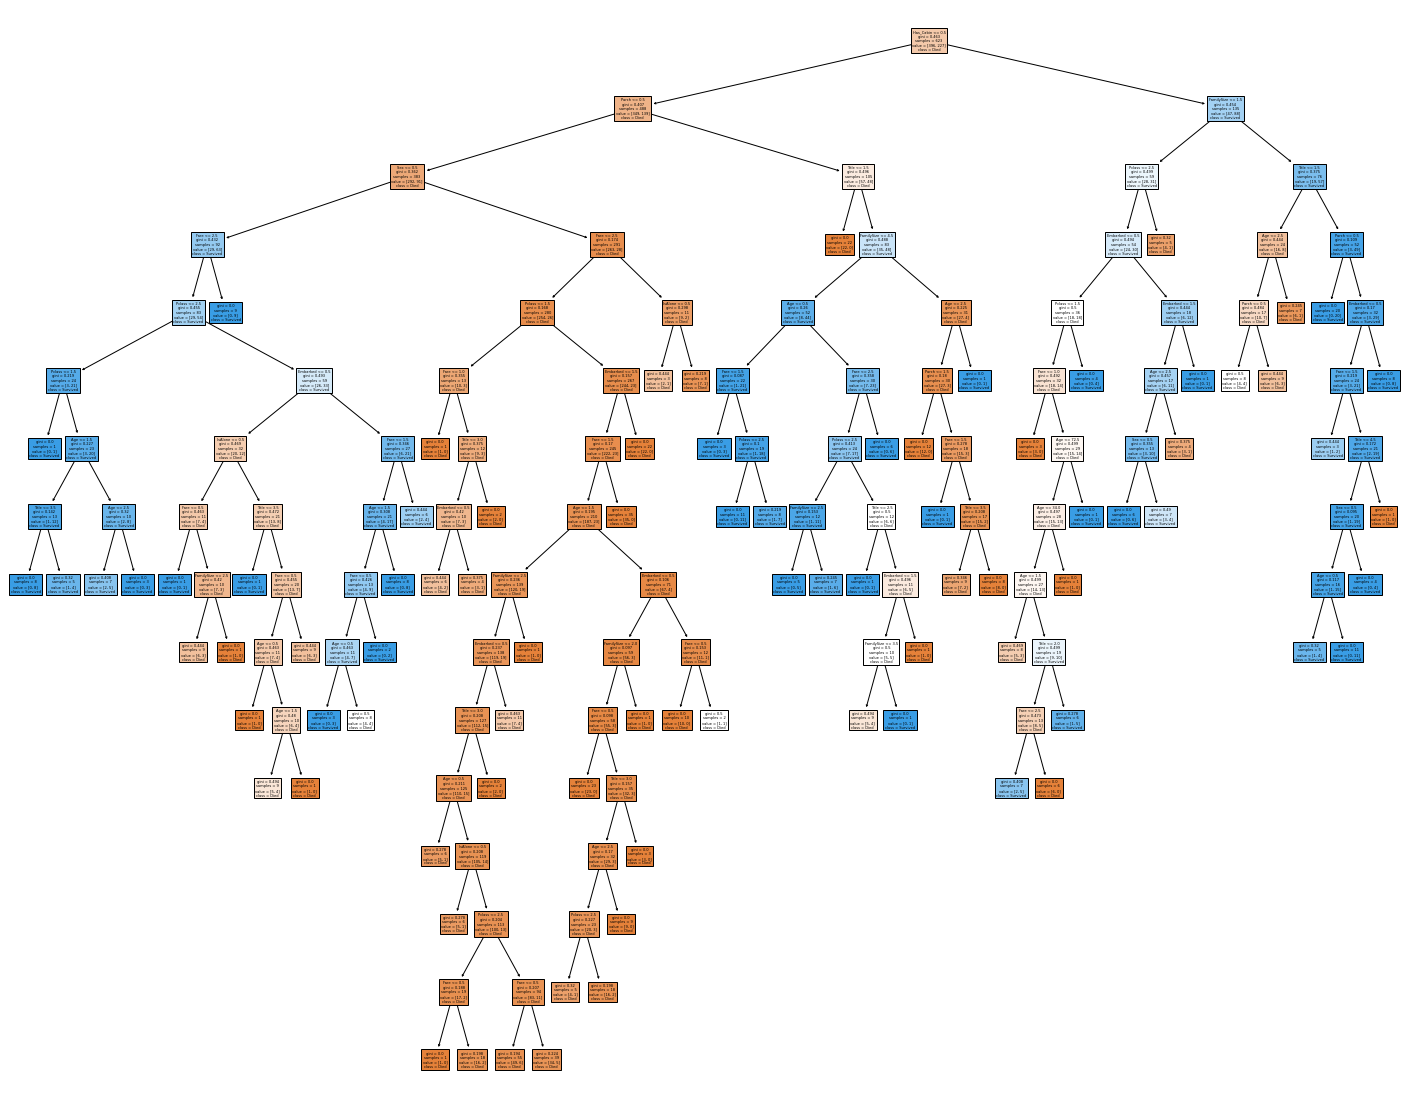

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

model = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=1,max_features='auto')
t1 = model.fit(X_train,y_train)

prediction_tree = model.predict(X_test)
print('The accuracy of the DecisionTree Classifier is',round(accuracy_score(prediction_tree,y_test)*100,2))

kfold = KFold(n_splits=5, random_state=None)
result_tree = cross_val_score(model,f,t,cv=5,scoring='accuracy')

print('The cross validated score for Decision Tree classifier is:',round(result_tree.mean()*100,2))

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(
    model, 
    feature_names = list(train_df.drop(['Survived'], axis=1)),
    class_names = ['Died', 'Survived'],
    filled=True)
# y_pred = cross_val_predict(model,f,t,cv=5)
# tree.plot_tree(t1)

In [11]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

NameError: name 'decision_tree' is not defined

In [13]:
f = train_df.drop("Survived",axis=1)
t = train_df["Survived"]
X_train,X_test,y_train,y_test = train_test_split(f,t,test_size=0.3,random_state=1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((623, 10), (268, 10), (623,), (268,))

In [14]:
model = RandomForestClassifier(
    criterion='gini',
    n_estimators=1000,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='auto',
    oob_score=True,
    n_jobs=-1)

model.fit(X_train,y_train)
prediction_rm=model.predict(X_test)
print('The accuracy of the Random Forest Classifier is', round(accuracy_score(prediction_rm,y_test)*100,2))
kfold = KFold(n_splits=5)
result_rm=cross_val_score(model,f,t,cv=5,scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))
y_pred = cross_val_predict(model,f,t,cv=5)

The accuracy of the Random Forest Classifier is 77.99
The cross validated score for Random Forest Classifier is: 81.26


TASK 6

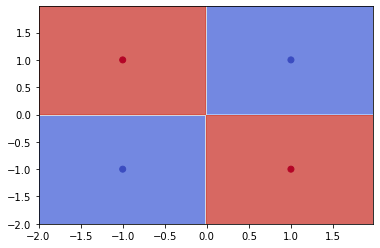

In [17]:
X = np.array([
    [-1, -1],
    [-1, 1],
    [1, -1],
    [1, 1]
])

y = np.array([0, 1, 1, 0])

h = .02

C = 1.0
poly_svc = svm.SVC(kernel='poly', degree=2, C=C).fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = poly_svc.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()